## Name: Abhishek Ajmera
## USC ID: 8586888981
## Github: abhishekajmera

In [1]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [4]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import pandas as pd
import numpy as np
import os
import cv2
import splitfolders
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")

In [6]:
data_path='/content/drive/My Drive/Colab Notebooks/MLDS/Data'
xls = pd.ExcelFile(os.path.join(data_path,'Classes.xlsx'))
classes = pd.read_excel(xls, 'Sheet1')
classes.columns

Index(['Folder Name ', 'Class'], dtype='object')

In [7]:
input_folder = os.path.join(data_path,'images')
output = os.path.join(data_path,'output_images')

In [8]:
splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.7, .15, .15))

Copying files: 1176 files [10:37,  1.85 files/s]


In [9]:
def random_crop(img, random_crop_size):
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

In [12]:
train_data_dir = os.path.join(output,'train')
valid_data_dir = os.path.join(output,'val')
image_size=224
batch_size=5
train_datagen = ImageDataGenerator(
    # rescale=1./255.,
    horizontal_flip = True,
    rotation_range = 45,  
    zoom_range = 0.2, 
    width_shift_range=0.3,
    shear_range=0.2,   
 
    validation_split=0)

valid_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')
train_crops = crop_generator(train_generator, 224)
validation_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 820 images belonging to 20 classes.
Found 171 images belonging to 20 classes.


In [14]:
x,y=next(train_generator)

### 1(c) Transfer Learning using EfficientNetB0

In [15]:
def build_model(num_classes):
    inputs = layers.Input(shape=(image_size, image_size, 3))
    
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
    model.trainable = False
    x=model(inputs,training=False)
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)   
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    opt = Adam(lr=0.001)
    model.compile(optimizer = opt , loss = "categorical_crossentropy" , metrics = ['accuracy'])
    return model

In [17]:
model = build_model(num_classes=20)
epochs = 100  
early = tf.keras.callbacks.EarlyStopping( patience=5,min_delta=0.001,monitor='val_loss',restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.001,patience=5, mode='min',verbose=1)
batch_size=5
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
history = model.fit_generator(train_crops,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    epochs=epochs,
                    callbacks=[early,reduce_lr])

16705208/16705208 [==============================] - 2s 0us/step
Epoch 1/100
164/164 [==============================] - 31s 114ms/step - loss: 2.0877 - accuracy: 0.4268 - val_loss: 1.0098 - val_accuracy: 0.8246 - lr: 0.0010
Epoch 2/100
164/164 [==============================] - 17s 102ms/step - loss: 0.9148 - accuracy: 0.7244 - val_loss: 0.4251 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 3/100
164/164 [==============================] - 16s 95ms/step - loss: 0.6508 - accuracy: 0.8037 - val_loss: 0.3007 - val_accuracy: 0.9181 - lr: 0.0010
Epoch 4/100
164/164 [==============================] - 16s 96ms/step - loss: 0.5578 - accuracy: 0.8220 - val_loss: 0.3056 - val_accuracy: 0.9240 - lr: 0.0010
Epoch 5/100
164/164 [==============================] - 16s 96ms/step - loss: 0.4748 - accuracy: 0.8415 - val_loss: 0.2736 - val_accuracy: 0.9240 - lr: 0.0010
Epoch 6/100
164/164 [==============================] - 16s 95ms/step - loss: 0.4721 - accuracy: 0.8402 - val_loss: 0.2363 - val_accuracy: 0.947

In [18]:
f = open("/content/drive/My Drive/Colab Notebooks/MLDS/Data/model1.pkl", "wb")
pickle.dump([model,history], f)
f.close()

In [19]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy vs epoch")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

def plot_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss vs epoch")
    plt.ylabel("Loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()    

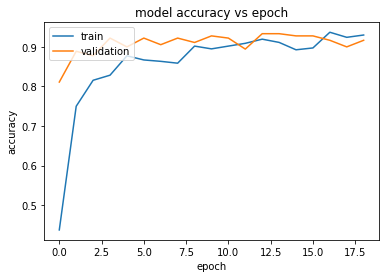

In [ ]:
plot_hist(history)

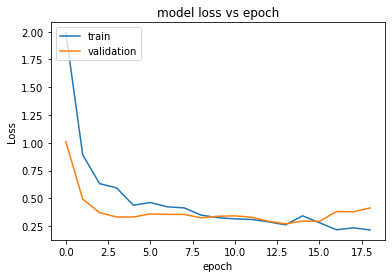

In [ ]:
plot_loss(history)

In [20]:
test_gen = ImageDataGenerator()
test_dir=os.path.join(output,'test')
test_generator =test_gen.flow_from_directory(test_dir,shuffle = False,target_size = (image_size,image_size),class_mode='categorical',batch_size=1)
filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.evaluate_generator(test_generator,steps = nb_samples)
print('Accuracy of EfficientNetB0 model:', predict[1])

Found 185 images belonging to 20 classes.
Accuracy of EfficientNetB0 model: 0.929729700088501


In [21]:
test_generator.reset()
y_pred_en = model.predict_generator(test_generator)
y_pred_en = np.array([np.argmax(x) for x in y_pred_en])
y_test_en = test_generator.classes

cm = confusion_matrix(y_test_en, y_pred_en)

In [22]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
classes=list(test_generator.class_indices.keys())
from sklearn.metrics import precision_score,recall_score,f1_score
precision_en=precision_score(y_test_en, y_pred_en, average=None)
recall_en=recall_score(y_test_en, y_pred_en, average=None)
f1_en=f1_score(y_test_en, y_pred_en, average=None)

en_results={'Classes':classes,'Precision':precision_en,'Recall':recall_en,'F1':f1_en}
en_results=pd.DataFrame(en_results)
en_results

,Classes,Precision,Recall,F1
0,005.Crested_Auklet,1.000000,1.000000,1.000000
1,013.Bobolink,1.000000,0.777778,0.875000
2,015.Lazuli_Bunting,1.000000,1.000000,1.000000
3,023.Brandt_Cormorant,1.000000,0.800000,0.888889
4,040.Olive_sided_Flycatcher,0.666667,0.666667,0.666667
5,041.Scissor_tailed_Flycatcher,0.888889,0.888889,0.888889
6,067.Anna_Hummingbird,1.000000,1.000000,1.000000
7,072.Pomarine_Jaeger,0.900000,1.000000,0.947368
8,076.Dark_eyed_Junco,1.000000,1.000000,1.000000
9,081.Pied_Kingfisher,1.000000,1.000000,1.000000


In [24]:
print('Mean Precision:', np.mean(precision_en))
print('Mean Recall:', np.mean(recall_en))
print('Mean F1:', np.mean(f1_en))

Mean Precision: 0.934040404040404
Mean Recall: 0.9299999999999999
Mean F1: 0.9293546365914788


## Transfer Learning using VGG16

In [25]:
def build_vgg_model(num_classes):
    inputs = layers.Input(shape=(image_size, image_size, 3))
    x=tf.keras.applications.vgg16.preprocess_input(inputs)
    
    model = VGG16(include_top=False, input_tensor=inputs, weights="imagenet")
    model.trainable = False
    x=model(inputs,training=False)
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)   
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    model = tf.keras.Model(inputs, outputs, name="VGG16")
    opt = Adam(lr=0.001)
    model.compile(optimizer = opt , loss = "categorical_crossentropy" , metrics = ['accuracy'])
    return model

In [26]:
vgg_model = build_vgg_model(num_classes=20)
epochs = 100  
early = tf.keras.callbacks.EarlyStopping( patience=5,min_delta=0.001,monitor='val_loss',restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.001,patience=5, mode='min',verbose=1)
batch_size=5
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
vgg_history = vgg_model.fit_generator(train_crops,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    epochs=epochs,
                    callbacks=[early,reduce_lr])

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/100
164/164 [==============================] - 20s 108ms/step - loss: 3.0955 - accuracy: 0.1183 - val_loss: 2.3456 - val_accuracy: 0.3567 - lr: 0.0010
Epoch 2/100
164/164 [==============================] - 16s 98ms/step - loss: 2.3896 - accuracy: 0.2622 - val_loss: 1.6129 - val_accuracy: 0.5322 - lr: 0.0010
Epoch 3/100
164/164 [==============================] - 16s 99ms/step - loss: 2.0015 - accuracy: 0.3915 - val_loss: 1.2912 - val_accuracy: 0.5965 - lr: 0.0010
Epoch 4/100
164/164 [==============================] - 18s 107ms/step - loss: 1.7379 - accuracy: 0.4890 - val_loss: 1.1725 - val_accuracy: 0.6257 - lr: 0.0010
Epoch 5/100
164/164 [==============================] - 16s 101ms/step - loss: 1.6292 - accuracy: 0.5073 - val_loss: 1.0391 - val_accuracy: 0.6784 - lr: 0.0010
Epoch 6/100
164/164 [==============================] - 16s 101ms/step - loss: 1.4335 - accuracy: 0.5659 - val_loss: 1.0438 - val_accuracy: 0.6

In [27]:
f = open("/content/drive/My Drive/Colab Notebooks/MLDS/Data/model2.pkl", "wb")
pickle.dump([vgg_model,vgg_history], f)
f.close()

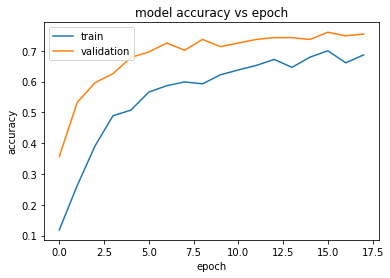

In [28]:
plot_hist(vgg_history)

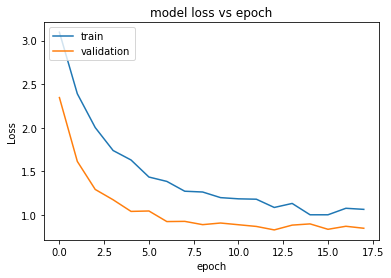

In [29]:
plot_loss(vgg_history)

In [30]:
test_gen = ImageDataGenerator()
test_dir=os.path.join(output,'test')
test_generator =test_gen.flow_from_directory(test_dir,shuffle = False,batch_size=1,target_size = (image_size,image_size))
test_generator.reset()
filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predict = vgg_model.evaluate_generator(test_generator, steps=nb_samples)

Found 185 images belonging to 20 classes.


In [31]:
print("Accuracy of VGG model:", vgg_predict[1])

Accuracy of VGG model: 0.7567567825317383


In [32]:
test_generator.reset()
y_pred = vgg_model.predict_generator(test_generator)
y_pred = np.array([np.argmax(x) for x in y_pred])
y_test = test_generator.classes
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
acc_each_class = cm.diagonal()
print('Accuracy for each class:\n',acc_each_class)

Accuracy for each class:
 [1.         0.77777778 0.5        0.7        0.44444444 0.88888889
 1.         0.88888889 0.88888889 1.         0.66666667 1.
 0.55555556 0.66666667 0.77777778 0.3        1.         0.5
 0.77777778 0.9       ]


In [33]:
classes=list(test_generator.class_indices.keys())
from sklearn.metrics import precision_score,recall_score,f1_score
precision_vgg=precision_score(y_test, y_pred, average=None)
recall_vgg=recall_score(y_test, y_pred, average=None)
f1_vgg=f1_score(y_test, y_pred, average=None)

vgg_results={'Classes':classes,'Precision':precision_vgg,'Recall':recall_vgg,'F1':f1_vgg}
vgg_results=pd.DataFrame(vgg_results)
vgg_results

,Classes,Precision,Recall,F1
0,005.Crested_Auklet,0.800000,1.000000,0.888889
1,013.Bobolink,0.777778,0.777778,0.777778
2,015.Lazuli_Bunting,0.714286,0.500000,0.588235
3,023.Brandt_Cormorant,0.700000,0.700000,0.700000
4,040.Olive_sided_Flycatcher,1.000000,0.444444,0.615385
5,041.Scissor_tailed_Flycatcher,0.470588,0.888889,0.615385
6,067.Anna_Hummingbird,0.818182,1.000000,0.900000
7,072.Pomarine_Jaeger,0.727273,0.888889,0.800000
8,076.Dark_eyed_Junco,0.727273,0.888889,0.800000
9,081.Pied_Kingfisher,0.900000,1.000000,0.947368


In [35]:
print('Mean Precision:', np.mean(precision_vgg))
print('Mean Recall:', np.mean(recall_vgg))
print('Mean F1:', np.mean(f1_vgg))

Mean Precision: 0.7765416772769714
Mean Recall: 0.7616666666666667
Mean F1: 0.7500253650718047
